Using GPU: Tesla T4
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Step [1/782], Loss: 0.0583
Epoch [1/30], Step [101/782], Loss: 0.0119
Epoch [1/30], Step [201/782], Loss: 0.0061
Epoch [1/30], Step [301/782], Loss: 0.0056
Epoch [1/30], Step [401/782], Loss: 0.0050
Epoch [1/30], Step [501/782], Loss: 0.0052
Epoch [1/30], Step [601/782], Loss: 0.0045
Epoch [1/30], Step [701/782], Loss: 0.0055
Epoch [2/30], Step [1/782], Loss: 0.0049
Epoch [2/30], Step [101/782], Loss: 0.0058
Epoch [2/30], Step [201/782], Loss: 0.0049
Epoch [2/30], Step [301/782], Loss: 0.0047
Epoch [2/30], Step [401/782], Loss: 0.0054
Epoch [2/30], Step [501/782], Loss: 0.0045
Epoch [2/30], Step [601/782], Loss: 0.0061
Epoch [2/30], Step [701/782], Loss: 0.0063
Epoch [3/30], Step [1/782], Loss: 0.0051
Epoch [3/30], Step [101/782], Loss: 0.0045
Epoch [3/30], Step [201/782], Loss: 0.0053
Epoch [3/30], Step [301/782], Loss: 0.0041
Epoch [3/30], Step [401/782], Loss: 0.0043
Epoch [

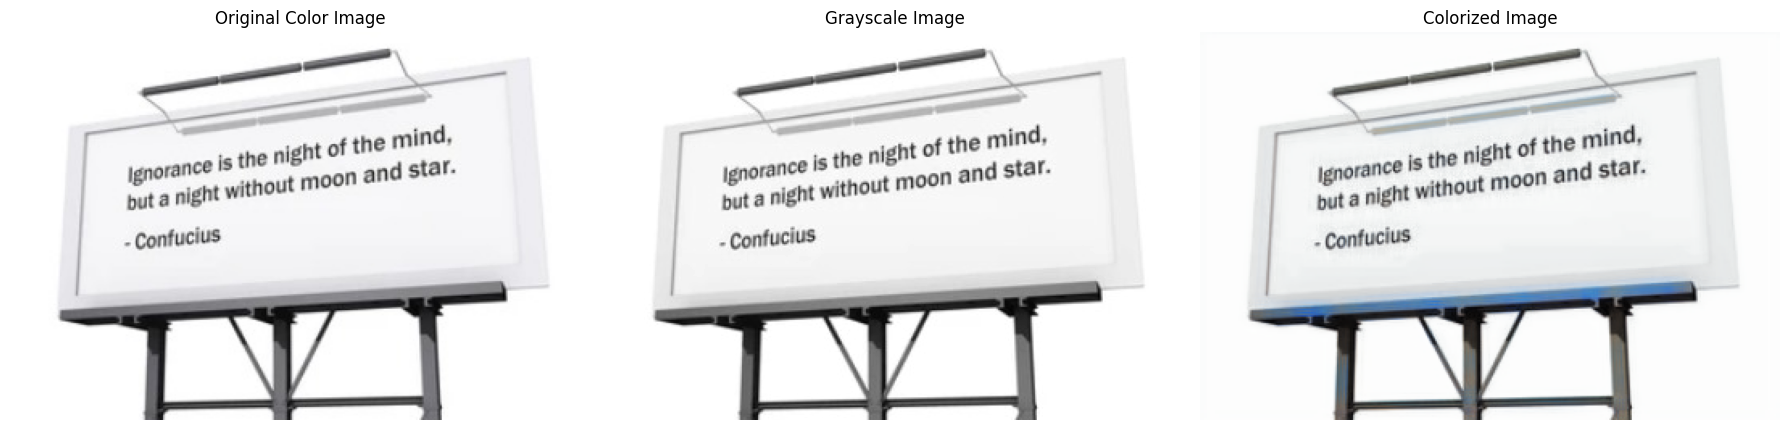

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 5s 5s/step
Extracted Text: mind the of night the ls ignorance star and moon without night but a confucius
Original: mind the of night the ls ignorance star and moon without night but a confucius
Translated: रात के अज्ञानता सितारे और रात के बिना चंद्रमा लेकिन एक कन्फ्यूशियस को ध्यान में रखें


In [1]:
# Install the required libraries
!pip install torch torchvision keras-ocr translate matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import keras_ocr
from translate import Translator

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No NVIDIA driver found. Using CPU")

# Data transformation
transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR-10 dataset (for training the model)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Define the colorization network
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

# Initialize model, loss, and optimizer
model = ColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def rgb_to_gray(img):
    """Convert RGB image to grayscale"""
    return img.mean(dim=1, keepdim=True)

# Training loop
EPOCHS = 30
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        # Forward pass
        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Finished Training")

# Load and process a sample image for colorization
image_path = '/content/WhatsApp Image 2024-11-14 at 08.53.23_58d24430.jpg'  # Image path
img = Image.open(image_path)
gray_img = img.convert("L")  # Convert image to grayscale
img_tensor = transform(gray_img).unsqueeze(0).to(device)

# Colorize the grayscale image
model.eval()
with torch.no_grad():
    colorized_tensor = model(img_tensor)

colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())
colorized_img.save("colorized_image.jpg")

# Visualize original, grayscale, and colorized images
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')
ax[1].imshow(gray_img, cmap='gray')
ax[1].set_title("Grayscale Image")
ax[1].axis('off')
ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')
plt.tight_layout()
plt.show()

# Save the grayscale image
gray_img.save("grayscale_image.jpg")

# Text extraction from image using Keras-OCR
def extract_text_from_image(image_path):
    """Extract text from image using Keras-OCR"""
    pipeline = keras_ocr.pipeline.Pipeline()
    images = [keras_ocr.tools.read(image_path)]
    prediction_groups = pipeline.recognize(images)
    predictions = prediction_groups[0]
    extracted_text = ' '.join([text for text, box in predictions])
    return extracted_text

# Example usage for text extraction
extracted_text = extract_text_from_image(image_path)
print("Extracted Text:", extracted_text)

# Translation of extracted text
translator = Translator(to_lang="hi")  # Specify the target language
text_to_translate = extracted_text
translation = translator.translate(text_to_translate)

print(f"Original: {text_to_translate}")
print(f"Translated: {translation}")


In [17]:
!pip install --force-reinstall tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.5 MB/s eta 0:0